In [6]:
# # Install Julia and IJulia
# ;curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz" -o julia.tar.gz
# ;tar -xvzf julia.tar.gz > /dev/null
# ;mv julia-1.9.3 /opt/julia
# ;ln -fs /opt/julia/bin/julia /usr/local/bin/julia

# # Install IJulia kernel
# ;julia -e 'using Pkg; Pkg.add("IJulia"); using IJulia;'



# LINMA2470 - Stochastic Modelling
## Project Statement - Part 1

# 1 - MDP environment

In [7]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
using LinearAlgebra
using TabularTDLearning         # Q‑Learning & SARSA solvers
using POMDPTools: EpsGreedyPolicy, DiscreteBelief

In [8]:


### Définir le MDP corrigé EddyBikes ###
const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5
const REPLENISH_WAREHOUSE_BATCH = 10

const holding_cost_store = 2
const holding_cost_parking = 4
const holding_cost_warehouse = 1
const order_cost = 20
const home_delivery_cost = 10
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 7)

mdp = QuickMDP(
    states = [(s1, s2, sw) for s1 in 0:MAX_INVENTORY, s2 in 0:MAX_INVENTORY, sw in 0:MAX_INVENTORY],
    actions = [(a1, a2, aw) for a1 in 0:1, a2 in 0:1, aw in 0:1],
    discount = 0.99,

    gen = function (s, a, rng)
        s1, s2, sw = s

        a1, a2, aw = a
        # if sw < 10 
        #     aw = 1
        # else 
        #     aw = 0
        # end

        # --- Réapprovisionnement usine vers warehouse ---
        new_sw = sw + (aw == 1 ? REPLENISH_WAREHOUSE_BATCH : 0)
        new_sw = min(new_sw, MAX_INVENTORY)

        # --- Commandes magasins ---
        order1 = a1 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s1) : 0
        order2 = a2 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s2) : 0

        total_requested = order1 + order2

        if total_requested <= new_sw
            actual_order1, actual_order2 = order1, order2
        else
            if s1 < s2
                actual_order1 = min(order1, new_sw)
                actual_order2 = new_sw - actual_order1
            else
                actual_order2 = min(order2, new_sw)
                actual_order1 = new_sw - actual_order2
            end
        end

        actual_order1 = min(actual_order1, ORDER_SIZE)
        actual_order2 = min(actual_order2, ORDER_SIZE)

        new_s1 = s1 + actual_order1
        new_s2 = s2 + actual_order2
        new_sw -= (actual_order1 + actual_order2)

        # --- Demandes clients ---
        d1 = rand(rng, demand_dist)
        d2 = rand(rng, demand_dist)

        sold1 = min(new_s1, d1)
        remaining_demand1 = d1 - sold1
        delivered1 = min(remaining_demand1, new_sw)
        lost_sales1 = remaining_demand1 - delivered1

        new_s1 -= sold1
        new_sw -= delivered1

        sold2 = min(new_s2, d2)
        remaining_demand2 = d2 - sold2
        delivered2 = min(remaining_demand2, new_sw)
        lost_sales2 = remaining_demand2 - delivered2

        new_s2 -= sold2
        new_sw -= delivered2

        # --- Coûts ---
        cost = 0
        cost += (a1 == 1 ? order_cost : 0) + (a2 == 1 ? order_cost : 0)
        #cost += (aw == 1 ? order_cost : 0)

        in_store1 = min(new_s1, MAX_STORE)
        in_parking1 = max(new_s1 - MAX_STORE, 0)
        cost += in_store1 * holding_cost_store + in_parking1 * holding_cost_parking

        cost += new_s2 * holding_cost_store
        cost += new_sw * holding_cost_warehouse
        cost += (delivered1 + delivered2) * home_delivery_cost
        cost += (lost_sales1 + lost_sales2) * stockout_penalty

        r = -cost
        return ((new_s1, new_s2, new_sw), r, (d1, d2))
    end,

    initialstate = Deterministic((10, 10, 10))
)


QuickMDP{Base.UUID("6ced13e0-b622-4d70-a427-3d698ee70f6b"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#19#22"}}((stateindex = Dict((19, 5, 6) => 2771, (6, 13, 14) => 6454, (20, 16, 1) => 798, (3, 9, 8) => 3721, (0, 2, 19) => 8422, (16, 15, 16) => 7388, (14, 12, 1) => 708, (11, 13, 15) => 6900, (16, 5, 3) => 1445, (18, 6, 19) => 8524…), isterminal = false, actionindex = Dict((0, 0, 0) => 1, (1, 1, 1) => 8, (1, 1, 0) => 4, (0, 1, 1) => 7, (0, 1, 0) => 3, (1, 0, 1) => 6, (1, 0, 0) => 2, (0, 0, 1) => 5), initialstate = Deterministic{Tuple{Int64, Int64, Int64}}((10, 10, 10)), states = [(0, 0, 0) (0, 1, 0) … (0, 19, 0) (0, 20, 0); (1, 0, 0) (1, 1, 0) … (1, 19, 0) (1, 2

In [9]:
rng = MersenneTwister(42)

scenarios = [
    ((4, 3, 10), (1, 0, 0)),  # store1 commande, pas store2, pas d'usine
    ((4, 3, 10), (1, 0, 1)),  # store1 commande, et réappro usine
    ((18, 18, 5), (1, 1, 1)), # magasins pleins, commande depuis usine
    ((5, 5, 0), (1, 1, 0)),   # entrepôt vide, demande forte
    ((0, 0, 20), (0, 0, 0)),  # rien ne se passe
    ((19, 19, 20), (0, 0, 1)),# stocks pleins, mais entrepôt recharge
    ((10, 10, 5), (1, 0, 1)), # 1 magasin commande, usine réapprovisionne
    ((7, 8, 2), (1, 1, 0)),   # compétition entre magasins, sans usine
    ((0, 20, 10), (1, 1, 1)), # un vide un plein, recharge usine
    ((2, 2, 2), (0, 1, 1)),   # un seul magasin commande
    ((15, 5, 0), (0, 1, 0)),  # un magasin haut stock, autre bas
]

for (s, a) in scenarios
    sp, r, d = POMDPs.gen(mdp, s, a, rng)
    println("From $s --(a=$a)--> $sp,  Demands: $d, Reward = $r")
end


From (4, 3, 10) --(a=(1, 0, 0))--> (8, 0, 1),  Demands: (1, 7), Reward = -77
From (4, 3, 10) --(a=(1, 0, 1))--> (6, 0, 13),  Demands: (3, 5), Reward = -65
From (18, 18, 5) --(a=(1, 1, 1))--> (15, 15, 11),  Demands: (5, 5), Reward = -121
From (5, 5, 0) --(a=(1, 1, 0))--> (0, 0, 0),  Demands: (7, 6), Reward = -190
From (0, 0, 20) --(a=(0, 0, 0))--> (0, 0, 19),  Demands: (1, 0), Reward = -29
From (19, 19, 20) --(a=(0, 0, 1))--> (18, 17, 20),  Demands: (1, 2), Reward = -106
From (10, 10, 5) --(a=(1, 0, 1))--> (10, 3, 10),  Demands: (5, 7), Reward = -56
From (7, 8, 2) --(a=(1, 1, 0))--> (8, 1, 0),  Demands: (1, 7), Reward = -58
From (0, 20, 10) --(a=(1, 1, 1))--> (4, 17, 15),  Demands: (1, 3), Reward = -97
From (2, 2, 2) --(a=(0, 1, 1))--> (2, 2, 7),  Demands: (0, 5), Reward = -35
From (15, 5, 0) --(a=(0, 1, 0))--> (8, 4, 0),  Demands: (7, 1), Reward = -44


# 2 - Q-Learning method

In [ ]:
n_states = 21 # 0 -> 20
n_actions = 2 # 0 ou 1
# Q = zeros(Float64, n_states, n_actions)


function my_Q_learning(
    mdp, α, ϵ, Q0;
    s_space = (0:20, 0:20, 0:20),              # ranges for (s1, s2, s3)
    a_space = Iterators.product(0:1, 0:1, 0:1),# list of 3-element actions
    epochs = 100, iterations = 10_000,
    s0 = (10, 10, 10), γ = 0.99
)
    rng = MersenneTwister(12344)

    n_s1, n_s2, n_s3 = length.(s_space)
    Q_temp = zeros(Float64, n_s1, n_s2, n_s3, 2, 2, 2)  # assumes binary actions for each dim
    Q_temp .= Q0

    ERR = []
    all_actions = collect(a_space)

    for i in 1:iterations
        s = s0

        for t in 1:epochs
            # ϵ-greedy action selection
            a = rand(rng) < ϵ ? rand(rng, all_actions) : begin
                max_a = nothing
                max_q = -Inf
                for a_candidate in all_actions
                    q_val = Q_temp[s[1]+1, s[2]+1, s[3]+1, a_candidate[1]+1, a_candidate[2]+1, a_candidate[3]+1]
                    if q_val > max_q
                        max_q = q_val
                        max_a = a_candidate
                    end
                end
                max_a
            end

            sp, r, _ = POMDPs.gen(mdp, s, a, rng)

            # Q update
            current_q = Q_temp[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1]
            future_q = maximum(Q_temp[sp[1]+1, sp[2]+1, sp[3]+1, :, :, :])
            Q_temp[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1] += α * (r + γ * future_q - current_q)

            s = sp
        end

        if i % 10 == 0
            err = norm(Q0 - Q_temp)
            push!(ERR, err)
            Q0 .= Q_temp
        end
    end

    return Q_temp, ERR
end


my_Q_learning (generic function with 1 method)

In [11]:
α = 0.1
ϵ = 0.1
s0 = (10, 10, 10)

# Q-table: 21 x 21 x 21 states, 2 x 2 x 2 actions
Q = zeros(Float64, n_states, n_states, n_states, n_actions, n_actions, n_actions)

Q, ERR = my_Q_learning(mdp, α, ϵ, Q, s0 = s0, epochs = 30, iterations = 1000)


([-420.73402306109114 -189.38500476586592 … 0.0 0.0; -182.82440217391192 -61.66482341656831 … 0.0 0.0; … ; -8.6 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -184.30977195795114 -73.03422749952827 … 0.0 0.0; -66.74734922072031 -0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -159.95829845983934 -96.16065941608794 … 0.0 0.0; -103.50766141141987 -28.299931536504722 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; -37.942418507393505 -4.3821 … 0.0 0.0; -8.3 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -13.03870393 -13.098603459972963 … 0.0 0.0; -16.89019700417441 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -3.8000000000000003 -9.44275311812 … 0.0 0.0; -5.6000000000000005 -2.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; -446.446605645382 -223.24454497976143 … 0.0 0.0; -268.3294539263371 -108.8416214716336 … 0.0 0.0; … ; -41.400000000000006 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -206.6118605397777 -86.621348103148 … 0.0 0.0; -50.69922083448

In [12]:
α = 0.1
ϵ = 0.01
s0 = (10, 10, 10)

# For states (0:20, 0:20, 0:20) and actions (0 or 1 in each of 3 dims)
Q = zeros(Float64, 21, 21, 21, 2, 2, 2)

Q, ERR2 = my_Q_learning(mdp, α, ϵ, Q, s0 = (10, 10, 10), epochs = 30, iterations = 10_000)


([-399.9335979755503 -359.45916482951316 … -77.14396423705648 -54.81083469132683; -336.6616980676306 -300.7530448454303 … -25.964318 -14.78996; … ; -49.95643779962842 -5.4 … 0.0 0.0; -43.61153452633977 -31.786397927749587 … 0.0 0.0;;; -362.73651604878125 -269.3450341422299 … -31.76660074 -24.6; -276.286884797423 -138.66591347511087 … 0.0 0.0; … ; -12.258501379048987 -39.765681429955215 … 0.0 0.0; -16.8094043347 -41.95016664488293 … 0.0 0.0;;; -318.2715570687766 -257.51184544996977 … -45.402137647085006 -20.83659258602017; -233.03329881005394 -164.58724809351844 … 0.0 -33.52505882245219; … ; -22.200000000000003 -13.449549111352031 … 0.0 0.0; -18.318700000000003 -17.308960739445915 … 0.0 0.0;;; … ;;; -232.13635722407702 -144.73709131147163 … -11.034370200000001 -9.603900000000001; -169.33935769487604 -14.528958797598932 … 0.0 0.0; … ; -11.9 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -234.87230919709833 -146.4133120460885 … -9.1 0.0; -139.16578515746423 -20.592559743846877 … 0.0 0.0; … ; 0.0 0.0

In [13]:
for e in ERR2
    push!(ERR, e)
end

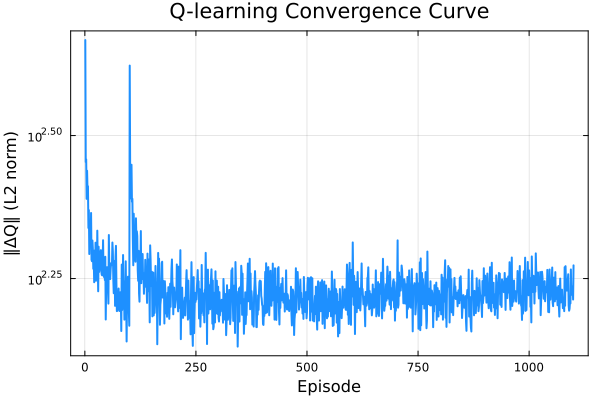

In [14]:
plot(ERR;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :dodgerblue,
    legend = false,
    title = "Q-learning Convergence Curve",
    grid = :on,
    framestyle = :box
)

Benchmarking the Q_learning

In [15]:
state_space = Iterators.product(0:20, 0:20, 0:20)
action_space = collect(Iterators.product(0:1, 0:1, 0:1))

policy = Dict()
for s in state_space
    best_q, best_a = findmax([
        (Q[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1], a)
        for a in action_space
    ])
    policy[s] = Tuple(best_a)
    @assert isa(policy[s], Tuple) "Action must be a tuple, got $(typeof(best_a))"

end


In [16]:
function benchmark_policy(policy::Dict, mdp; episodes=1_000_000, horizon=30, rng=MersenneTwister(42))
    total_rewards = zeros(episodes)

    for ep in 1:episodes
        s = (10, 10, 10)  # start state as a tuple
        ep_reward = 0.0

        for t in 1:horizon
            a = policy[s]  # select action from learned policy
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)  # simulate next step
            ep_reward += r
            s = sp
        end

        total_rewards[ep] = ep_reward
    end

    mean_reward = mean(total_rewards)
    std_reward = std(total_rewards)

    return mean_reward, std_reward, total_rewards
end


benchmark_policy (generic function with 1 method)

Benchmark results for learned Q-learning policy:
  Mean total reward over episodes: -9400.327613
  Std. deviation: 1264.2628679848672


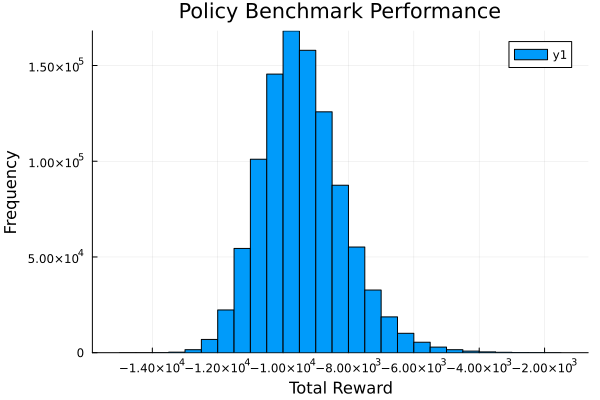

In [17]:
mean_r, std_r, rewards = benchmark_policy(policy, mdp)

println("Benchmark results for learned Q-learning policy:")
println("  Mean total reward over episodes: $mean_r")
println("  Std. deviation: $std_r")

using Plots
histogram(rewards, bins=30, xlabel="Total Reward", ylabel="Frequency", title="Policy Benchmark Performance")


In [18]:
using Statistics

N_eval = 10_000
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]

returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

state_space = collect(Iterators.product(0:20, 0:20, 0:20))
action_space = collect(Iterators.product(0:1, 0:1, 0:1))

println("Starting benchmark for tuple-based Q-learning:")
@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
       println("α = $α | ϵ = $ϵ")

       Q = zeros(Float64, 21, 21, 21, 2, 2, 2)
       Q, _ = my_Q_learning(mdp, α, ϵ, Q; epochs=30, iterations=10_000, s0=(10,10,10))

       # Build greedy policy π as a Dict
       π = Dict()
       for s in state_space
           best_q, best_a = findmax([
               (Q[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1], a)
               for a in action_space
           ])
           π[s] = Tuple(best_a)
       end

       # Evaluate policy
       total_rewards = zeros(N_eval)
       for k in 1:N_eval
           s = (10, 10, 10)
           total_r = 0.0
           for t in 1:30
               a = π[s]
               sp, r, _ = POMDPs.gen(mdp, s, a, MersenneTwister(k))  # or fixed RNG
               total_r = r + 0.99 * total_r
               s = sp
           end
           total_rewards[k] = total_r
       end

       returns_mean[i, j] = mean(total_rewards)
       returns_std[i, j] = std(total_rewards)
   end
end



Starting benchmark for tuple-based Q-learning:
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
α = 0.2 | ϵ = 0.1
α = 0.2 | ϵ = 0.01
α = 0.2 | ϵ = 1.0e-5
α = 0.1 | ϵ = 0.2
α = 0.1 | ϵ = 0.1
α = 0.1 | ϵ = 0.01
α = 0.1 | ϵ = 1.0e-5
α = 0.01 | ϵ = 0.2
α = 0.01 | ϵ = 0.1
α = 0.01 | ϵ = 0.01
α = 0.01 | ϵ = 1.0e-5
α = 1.0e-5 | ϵ = 0.2
α = 1.0e-5 | ϵ = 0.1
α = 1.0e-5 | ϵ = 0.01
α = 1.0e-5 | ϵ = 1.0e-5


In [19]:
returns_mean

4×4 Matrix{Float64}:
 -8636.41  -8126.83  -7850.15  -7820.2
 -8312.34  -7794.42  -8613.88  -8089.23
 -7636.72  -7711.17  -7689.93  -8047.28
 -7053.39  -7270.42  -7557.33  -8037.33

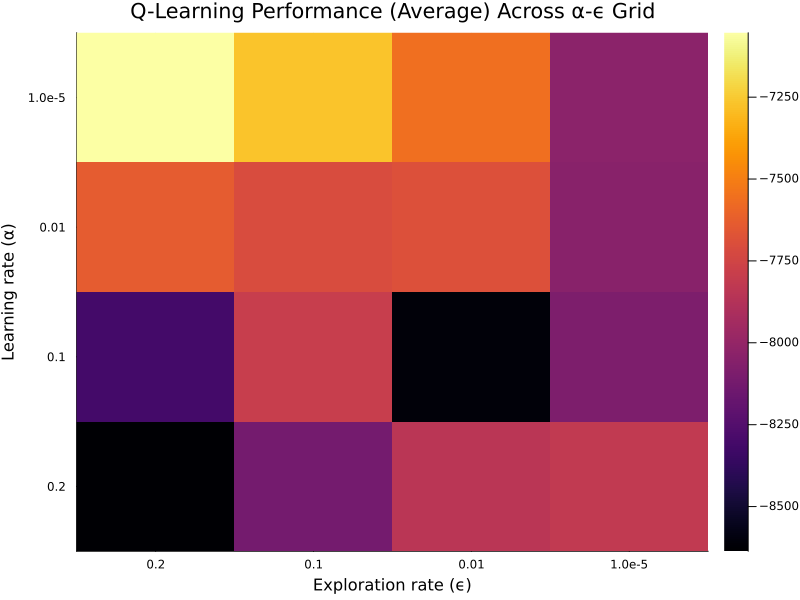

In [20]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

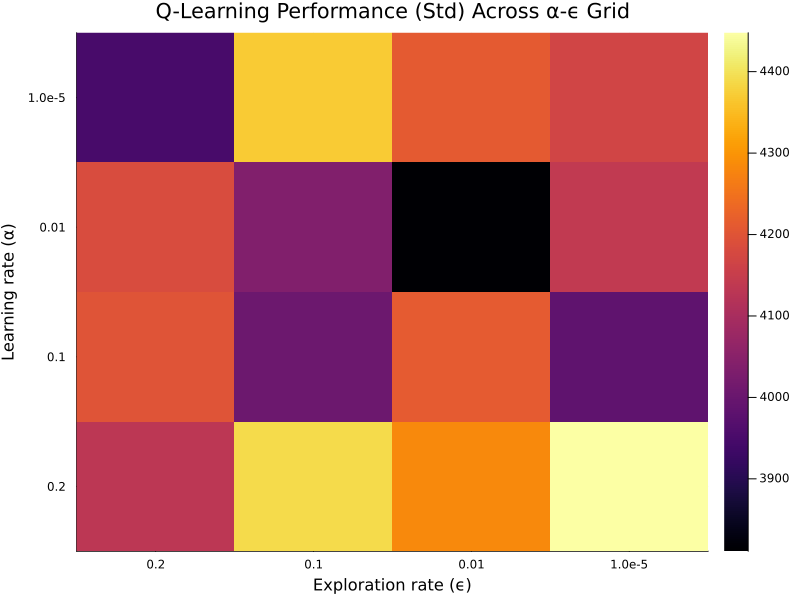

In [21]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# 3 - SARSA Method

In [67]:
function my_SARSA(
    mdp, α, ϵ, Q0;
    s_space = (0:20, 0:20, 0:20),
    a_space = Iterators.product(0:1, 0:1, 0:1),
    epochs = 100, iterations = 10_000,
    s0 = (10, 10, 10), γ = 0.99
)
    rng = MersenneTwister(12344)
    n_s1, n_s2, n_s3 = length.(s_space)
    Q_temp = copy(Q0)
    ERR = []

    all_actions = collect(a_space)  # ✅ Vecteur de tuples (0,1,0), etc.

    for i in 1:iterations
        s = s0

        # ε-greedy action initiale
        a = rand(rng) < ϵ ? rand(rng, all_actions) : begin
            max_a = nothing
            max_q = -Inf
            for a_candidate in all_actions
                q_val = Q_temp[s[1]+1, s[2]+1, s[3]+1,
                               a_candidate[1]+1, a_candidate[2]+1, a_candidate[3]+1]
                if q_val > max_q
                    max_q = q_val
                    max_a = a_candidate
                end
            end
            max_a
        end

        for t in 1:epochs
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)

            ap = rand(rng) < ϵ ? rand(rng, all_actions) : begin
                max_ap = nothing
                max_q = -Inf
                for a_candidate in all_actions
                    q_val = Q_temp[sp[1]+1, sp[2]+1, sp[3]+1,
                                   a_candidate[1]+1, a_candidate[2]+1, a_candidate[3]+1]
                    if q_val > max_q
                        max_q = q_val
                        max_ap = a_candidate
                    end
                end
                max_ap
            end

            # SARSA update
            Q_temp[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1] +=
                α * (r + γ * Q_temp[sp[1]+1, sp[2]+1, sp[3]+1,
                                    ap[1]+1, ap[2]+1, ap[3]+1] -
                     Q_temp[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1])

            s = sp
            a = ap
        end

        if i % 10 == 0
            err = norm(Q0 - Q_temp)
            push!(ERR, err)
            Q0 .= Q_temp
        end
    end

    return Q_temp, ERR
end


my_SARSA (generic function with 1 method)

In [68]:
α = 0.1
ϵ = 0.01
s0 = (10, 10, 10)
Q = zeros(Float64, 21, 21, 21, 2, 2, 2)

Q_sarsa, ERR_sarsa = my_SARSA(mdp, α, ϵ, Q;
    s0 = s0, epochs = 30, iterations = 10_000)


([-481.3450817301139 -328.6261046246228 … -77.24395021827918 -52.69278979531658; -340.4056235535248 -286.3836102437552 … -38.24001149497929 -26.76069597174131; … ; -77.79288299301263 -18.384330345049285 … 0.0 0.0; -62.293655296151506 -22.55343766983008 … 0.0 0.0;;; -340.61697259679494 -250.87256723866574 … -21.41989643145046 -15.609800000000002; -247.6613086842562 -143.13904079951914 … -20.161791721133152 -13.500315014121306; … ; -22.53649385 -32.137937548535106 … 0.0 0.0; -18.2663435548 -27.0 … 0.0 0.0;;; -318.04209647704846 -243.62191393168456 … -29.398158201417733 -4.9; -259.61666284910524 -123.10602544017746 … -30.4876695944411 -8.547842301927938; … ; -14.808441723640346 0.0 … 0.0 0.0; -33.0 -5.284417005221883 … 0.0 0.0;;; … ;;; -230.97852190950604 -169.5536023227369 … 0.0 0.0; -158.86094961683978 -20.63632058346597 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -227.45613977993494 -177.59352284555865 … -14.022423468790386 0.0; -147.8216244688148 -16.20700101773344 … 0.0 0.

In [69]:
s = 10
α = 0.1
ϵ = 0.01
Q, ERR2 = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 10000)

([-501.35447415564323 -457.2611761687084 … -140.989822849444 -116.9164913640249; -450.8432725257774 -375.6443838038415 … -38.24001149497929 -26.76069597174131; … ; -113.7932233532927 -18.384330345049285 … -7.0 -7.2; -92.54760426213741 -22.55343766983008 … 0.0 0.0;;; -424.57848898729094 -359.0098538072185 … -85.09479441702837 -45.28852183372101; -343.0781773697711 -193.50721639903347 … -20.161791721133152 -13.500315014121306; … ; -53.67545997532338 -32.137937548535106 … 0.0 0.0; -34.63170325482035 -27.0 … 0.0 0.0;;; -465.88629120778916 -374.6097911556203 … -66.65572307434554 -31.733473530859875; -337.57838375374513 -244.57907273593582 … -30.4876695944411 -8.547842301927938; … ; -54.75579717479984 -16.57130644204849 … 0.0 0.0; -33.0 -5.284417005221883 … 0.0 0.0;;; … ;;; -309.01040356181613 -261.2707375184043 … -6.897799656421544 -10.977115019150585; -247.92541575312427 -86.76003225028366 … -6.300000000000001 0.0; … ; -7.6000000000000005 -8.789825682779584 … 0.0 0.0; -7.4 -7.2 … 0.0 0.0;;

In [70]:
for e in ERR2
    push!(ERR, e)
end

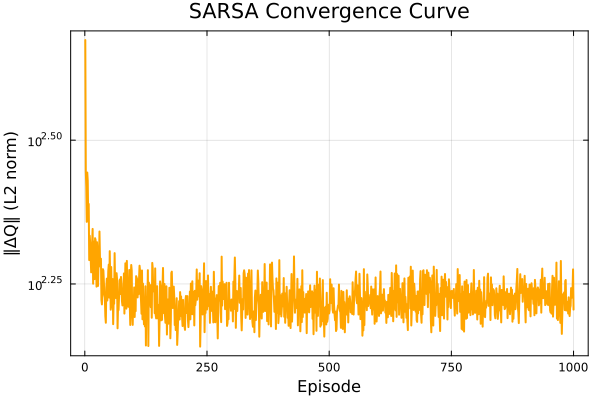

In [72]:
using Plots
plot(ERR_sarsa;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :orange,
    legend = false,
    title = "SARSA Convergence Curve",
    grid = :on,
    framestyle = :box
)


Benchmarking SARSA

In [77]:
using Statistics, Random

N_eval = 10_000
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]

returns_mean_sarsa = zeros(length(alphas), length(epsilons))
returns_std_sarsa = zeros(length(alphas), length(epsilons))

state_space = collect(Iterators.product(0:20, 0:20, 0:20))
action_space = collect(Iterators.product(0:1, 0:1, 0:1))  # ✅ tuples garantis

println("Starting benchmark for tuple-based SARSA:")
@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
    for (j, ϵ) in enumerate(epsilons)
        println("α = $α | ϵ = $ϵ")

        # Initialiser Q
        Q = zeros(Float64, 21, 21, 21, 2, 2, 2)
        Q, _ = my_SARSA(mdp, α, ϵ, Q; epochs=30, iterations=10_000, s0=(10, 10, 10))

        # Construire politique greedy π
        π = Dict()
        for s in state_space
            best_q, best_a = findmax([
                (Q[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1], a)
                for a in action_space
            ])
            π[s] = Tuple(best_a)
            @assert isa(π[s], Tuple)
        end

        # Évaluer la politique sur N_eval épisodes
        total_rewards = zeros(N_eval)
        for k in 1:N_eval
            s = (10, 10, 10)
            total_r = 0.0
            rng = MersenneTwister(k)

            for t in 1:30
                a = π[s]
                sp, r, _ = POMDPs.gen(mdp, s, a, rng)
                total_r = r + 0.99 * total_r
                s = sp
            end
            total_rewards[k] = total_r
        end

        returns_mean_sarsa[i, j] = mean(total_rewards)
        returns_std_sarsa[i, j] = std(total_rewards)
    end
end


Starting benchmark for tuple-based SARSA:
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
α = 0.2 | ϵ = 0.1
α = 0.2 | ϵ = 0.01
α = 0.2 | ϵ = 1.0e-5
α = 0.1 | ϵ = 0.2
α = 0.1 | ϵ = 0.1
α = 0.1 | ϵ = 0.01
α = 0.1 | ϵ = 1.0e-5
α = 0.01 | ϵ = 0.2
α = 0.01 | ϵ = 0.1
α = 0.01 | ϵ = 0.01
α = 0.01 | ϵ = 1.0e-5
α = 1.0e-5 | ϵ = 0.2
α = 1.0e-5 | ϵ = 0.1
α = 1.0e-5 | ϵ = 0.01
α = 1.0e-5 | ϵ = 1.0e-5


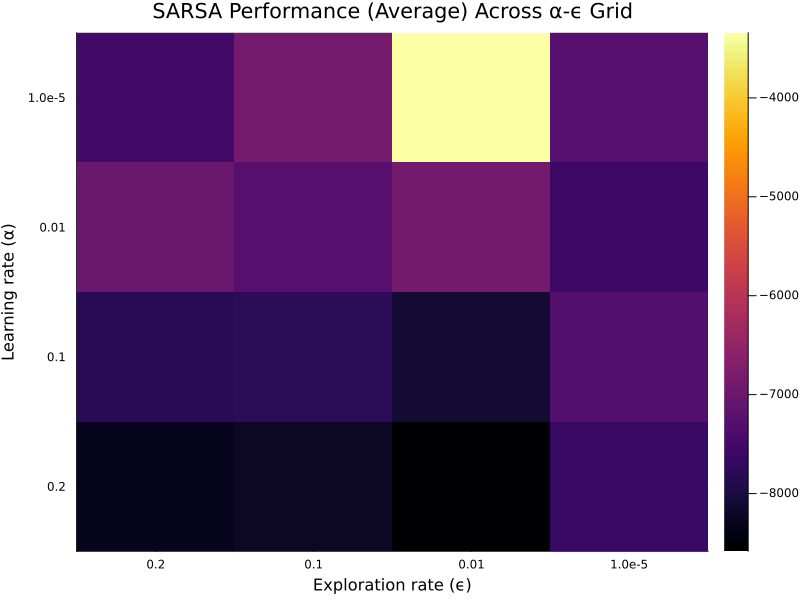

In [78]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean_sarsa;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

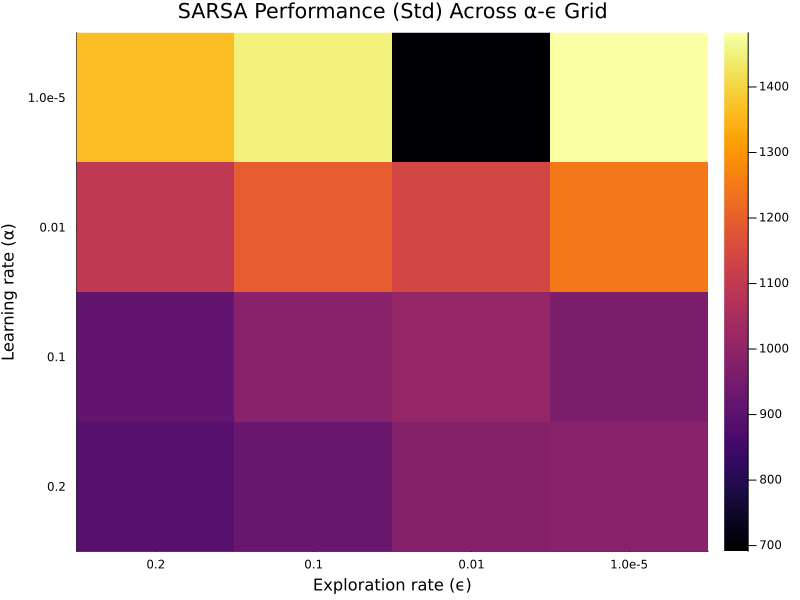

In [79]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std_sarsa;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# 4 - Comparison with POMDS.jl

In [30]:
mdp_q3 = QuickMDP(
    states     = 0:MAX_INVENTORY,
    actions    = [0, 1],
    discount   = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty

        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold

        lost_sales = max(d - new_stock, 0)

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty

        r = -cost

        return (sp=sp, r=r)
    end,

    initialstate = Deterministic(10)
)

QuickMDP{Base.UUID("6e9a94bf-dfe5-497c-a3d9-54b9e69eb8e1"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#36#37"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#36#37"()))

QLearningSolver

In [31]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))


function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the QLearningSolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")

      ql_solver   = QLearningSolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      ql_policy = solve(ql_solver,   mdp_q3)

      π_ql = policy_vector(ql_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_ql[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end

Starting benchmark for the QLearningSolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -1103.5325864565314
On Iteration 200, Returns: -1031.358388138875
On Iteration 300, Returns: -1309.2363963634887
On Iteration 400, Returns: -917.1294676642027
On Iteration 500, Returns: -1258.4092397817933
On Iteration 600, Returns: -895.5001925336121
On Iteration 700, Returns: -982.5782331523744
On Iteration 800, Returns: -1010.755272092282
On Iteration 900, Returns: -639.4496327632323
On Iteration 1000, Returns: -681.9735019092196
On Iteration 1100, Returns: -747.2459730078342
On Iteration 1200, Returns: -643.4665738272029
On Iteration 1300, Returns: -644.2326972331036
On Iteration 1400, Returns: -637.6294787688115
On Iteration 1500, Returns: -691.8514926403531
On Iteration 1600, Returns: -631.3461361570993
On Iteration 1700, Returns: -631.900594515098
On Iteration 1800, Returns: -630.3323204600499
On Iteration 1900, Retur

BoundsError: BoundsError: attempt to access Int64 at index [2]

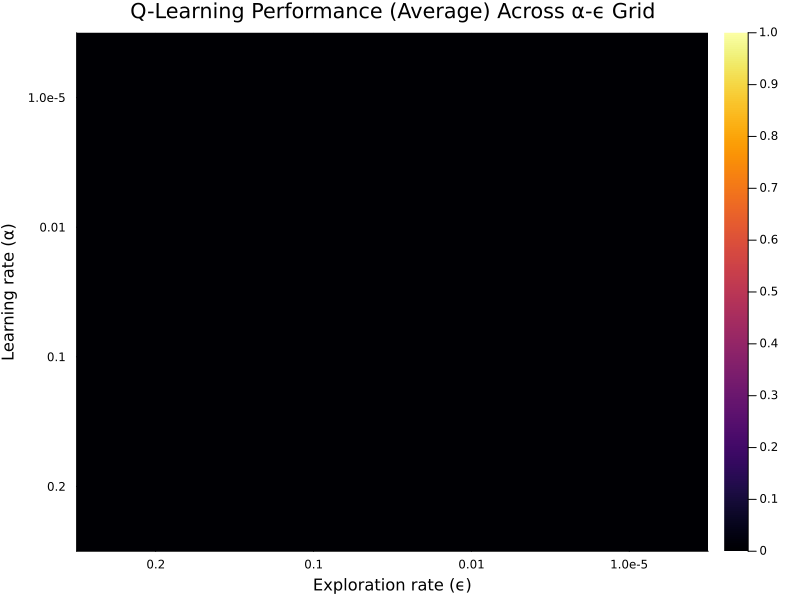

In [32]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [33]:
returns_mean

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

SARSASolver

In [34]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the SARSASolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")

      sarsa_solver   = SARSASolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      sarsa_policy = solve(sarsa_solver,   mdp_q3)

      π_sarsa = policy_vector(sarsa_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_sarsa[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end


Starting benchmark for the SARSASolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -934.8752104721127
On Iteration 200, Returns: -637.8036404875472
On Iteration 300, Returns: -1050.9301021067338
On Iteration 400, Returns: -825.8469825966498
On Iteration 500, Returns: -900.5351630004651
On Iteration 600, Returns: -961.1008359593508
On Iteration 700, Returns: -808.1026644980041
On Iteration 800, Returns: -690.2786557818224
On Iteration 900, Returns: -890.2155353771225
On Iteration 1000, Returns: -638.7673666841052
On Iteration 1100, Returns: -793.7140257157115
On Iteration 1200, Returns: -706.7981045914828
On Iteration 1300, Returns: -706.5022891246438
On Iteration 1400, Returns: -801.6809758064107
On Iteration 1500, Returns: -795.7952034321119
On Iteration 1600, Returns: -674.8593498937192
On Iteration 1700, Returns: -806.7072643055352
On Iteration 1800, Returns: -672.355444694459
On Iteration 1900, Returns: -6

BoundsError: BoundsError: attempt to access Int64 at index [2]

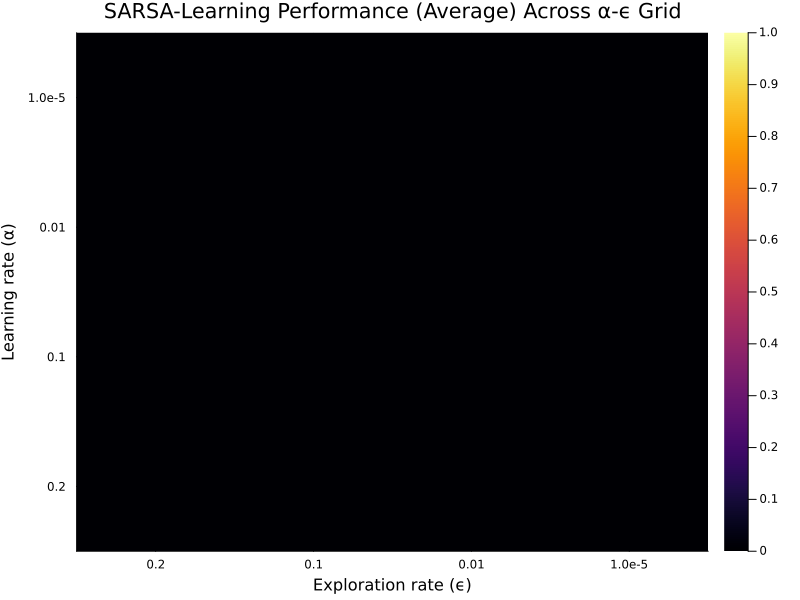

In [35]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [36]:
returns_mean

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

# 5 - Optimal policy

## Value iteration

In [37]:
function estimate_transitions_and_rewards(mdp; n_samples=1000)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    P = [Dict{Int, Float64}() for s in 0:MAX_INVENTORY, a in 0:1]
    R = zeros(n_states, n_actions)

    rng = MersenneTwister(123)

    for s in 0:MAX_INVENTORY
        for a in 0:1
            outcomes = Dict{Int, Vector{Float64}}()

            for _ in 1:n_samples
                sp, r, _ = POMDPs.gen(mdp, s, a, rng)
                if !haskey(outcomes, sp)
                    outcomes[sp] = []
                end
                push!(outcomes[sp], r)
            end

            total_r = 0.0
            for (sp, rewards) in outcomes
                P[s+1, a+1][sp] = length(rewards) / n_samples
                avg_r = mean(rewards)
                total_r += avg_r * (length(rewards) / n_samples)
            end
            R[s+1, a+1] = total_r
        end
    end

    return P, R
end


estimate_transitions_and_rewards (generic function with 1 method)

In [38]:
function value_iteration_tabular(P, R; γ=0.99, θ=1e-4, max_iters=1000)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    V = zeros(n_states)
    π = fill(0, n_states)

    for iter in 1:max_iters
        Δ = 0.0
        for s in 0:MAX_INVENTORY
            v = V[s+1]
            q_values = zeros(n_actions)

            for a in 0:1
                for (sp, p) in P[s+1, a+1]
                    q_values[a+1] += p * (R[s+1, a+1] + γ * V[sp+1])
                end
            end

            V[s+1] = maximum(q_values)
            π[s+1] = argmax(q_values) - 1
            Δ = max(Δ, abs(v - V[s+1]))
        end

        if Δ < θ
            println("Value Iteration Converged in $iter iterations.")
            break
        end
    end

    return V, π
end


value_iteration_tabular (generic function with 1 method)

In [39]:
P, R = estimate_transitions_and_rewards(mdp)
V_opt, π_opt = value_iteration_tabular(P, R)

Q_sarsa, _ = my_SARSA(mdp, 0.2, 0.3, zeros(Float64, n_states, n_actions))
Q_qlearning, _ = my_Q_learing(mdp, 0.2, 0.3, zeros(Float64, n_states, n_actions))
π_sarsa = [argmax(Q_sarsa[s+1, :]) - 1 for s in 0:MAX_INVENTORY]
π_qlearning = [argmax(Q_qlearning[s+1, :]) - 1 for s in 0:MAX_INVENTORY]

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [40]:
states_range = 0:MAX_INVENTORY

plot(
    states_range, π_opt,
    label = "Value Iteration",
    lw = 2, marker = :circle,
    xlabel = "Inventory State",
    ylabel = "Action",
    title = "Policy Comparison"
)

plot!(states_range, π_sarsa, label = "SARSA", lw = 2, marker = :star5)
plot!(states_range, π_qlearning, label = "Q-Learning", lw = 2, marker = :diamond)


UndefVarError: UndefVarError: `π_opt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [41]:
println("Policy agreement with Value Iteration:")

println("SARSA agreement: ", sum(π_sarsa .== π_opt), "/", length(π_opt))
println("Q-Learning agreement: ", sum(π_qlearning .== π_opt), "/", length(π_opt))

Policy agreement with Value Iteration:


UndefVarError: UndefVarError: `π_sarsa` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Linear programming formulation

In [42]:
P, R = estimate_transitions_and_rewards(mdp)

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [43]:
function solve_lp_mdp(P, R; γ=0.99)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    model = Model(GLPK.Optimizer)

    @variable(model, V[1:n_states])
    @objective(model, Min, sum(V))

    for s in 0:MAX_INVENTORY
        for a in 0:1
            lhs = 0.0
            for (sp, p) in P[s+1, a+1]
                lhs += p * (R[s+1, a+1] + γ * V[sp+1])
            end
            @constraint(model, V[s+1] >= lhs)
        end
    end

    optimize!(model)

    if termination_status(model) != MOI.OPTIMAL
        error("LP did not converge to an optimal solution.")
    end

    V_star = JuMP.value.(V)
    π_lp = fill(0, n_states)

    # Extract greedy policy from V*
    for s in 0:MAX_INVENTORY
        q_vals = zeros(n_actions)
        for a in 0:1
            for (sp, p) in P[s+1, a+1]
                q_vals[a+1] += p * (R[s+1, a+1] + γ * V_star[sp+1])
            end
        end
        π_lp[s+1] = argmax(q_vals) - 1
    end

    return V_star, π_lp
end

solve_lp_mdp (generic function with 1 method)

In [44]:
V_lp, π_lp = solve_lp_mdp(P, R)

UndefVarError: UndefVarError: `P` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [45]:
plot(
    0:MAX_INVENTORY, π_lp,
    label = "Linear Programming",
    lw = 2, marker = :circle,
    title = "Policy Comparison",
    xlabel = "State",
    ylabel = "Action"
)
plot!(0:MAX_INVENTORY, π_opt, label = "Value Iteration")
plot!(0:MAX_INVENTORY, π_sarsa, label = "SARSA")
plot!(0:MAX_INVENTORY, π_qlearning, label = "Q-Learning")

UndefVarError: UndefVarError: `π_lp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [46]:
println("Agreement with LP-derived policy:")
println("SARSA: ", sum(π_sarsa .== π_lp), "/", length(π_lp))
println("Q-Learning: ", sum(π_qlearning .== π_lp), "/", length(π_lp))
println("Value Iteration: ", sum(π_opt .== π_lp), "/", length(π_lp))

Agreement with LP-derived policy:


UndefVarError: UndefVarError: `π_sarsa` not defined in `Main`
Suggestion: check for spelling errors or missing imports.